In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d import web

In [2]:
runtime = 100.0 # in unit of 1/frequency bandwidth of the source
dPML = 1.0 # space between PhC slabs and PML, in unit of longest wavelength of interest

In [3]:
# Wavelength and frequency range
freq_range = (75e12, 135e12)
lambda_range = (td.constants.C_0/freq_range[1], td.constants.C_0/freq_range[0])
freq0 = np.sum(freq_range)/2

# central frequency, frequency pulse width
lambda0 = td.C_0 / freq0
width = 0.3
freqw  = width * (freq_range[1] - freq_range[0])

# runtime
t_stop = runtime/freqw
print(f"Total runtime <= {t_stop*1e12} ps")

# frequencies and wavelengths of monitor
Nfreq = 1001
monitor_freqs = np.linspace(freq_range[0], freq_range[1], Nfreq)
monitor_lambdas = td.constants.C_0 / monitor_freqs

# PhC slab
period = 1.0 # um, period along x- and y- direction
t_slab = 0.55 # um, thickness
ep_slab = 12 # permittivity
mat_slab = td.Medium(permittivity=ep_slab, name='silicon')

# PhC air hole
radius = 0.2 # um, radius
ep_hole = 1 #permittivity
mat_hole = td.Medium(permittivity=ep_hole, name='air')

# Grid size # um
dl = lambda_range[0] / 30 / np.sqrt(ep_slab) # 30 grids per smallest wavelength in medium
print(f"dl = {dl*1000} nm")

# space between PhC slabs and PML
spacing = dPML * lambda_range[-1]

# simulation size
sim_size = Lx, Ly, Lz = (period, period, 2*spacing + t_slab)

Total runtime <= 5.555555555555555 ps
dl = 21.368550163866615 nm


In [4]:
slab = td.Structure(
    geometry=td.Box(
        center=(0, 0, 0),
        size=(td.inf,td.inf,t_slab),
    ),
    medium=mat_slab,
    name='slab',
)

hole = td.Structure(
    geometry=td.Cylinder(
        center=(0, 0, 0),
        axis=2,
        radius=radius,
        length=t_slab,
    ),
    medium=mat_hole,
    name='air hole',
)

In [6]:
# Here we define the planewave source, placed just in advance (towards negative z) of the slab
source = td.PlaneWave(
    source_time = td.GaussianPulse(
        freq0=freq0,
        fwidth=freqw
    ),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -Lz/2+spacing/2),
    direction='+',
    pol_angle=0,
    name='planewave',
)

In [7]:
# We are interested in measuring the transmitted flux, so we set it to be an oversized plane.
monitor = td.FluxMonitor(
    center = (0, 0, Lz/2 - spacing/2),
    size = (td.inf, td.inf, 0),
    freqs = monitor_freqs,
    name='flux',
)

In [8]:
# We are interested in measuring the time evolution at a single point in the field monitor plane
monitor_time = td.FieldTimeMonitor(
    center = (0, 0, Lz/2 - spacing/2),
    size = (0, 0, 0),
    fields = ['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz'],
    name='time',
)

In [9]:
sim = td.Simulation(
    center = (0, 0, 0),
    size = sim_size,
    grid_spec = td.GridSpec.uniform(dl=dl),
    structures = [slab,hole],
    sources = [source],
    monitors = [monitor,monitor_time],
    run_time = t_stop,
    shutoff = 1e-7,
    boundary_spec = td.BoundarySpec.pml(z=True),
    normalize_index = None,
)

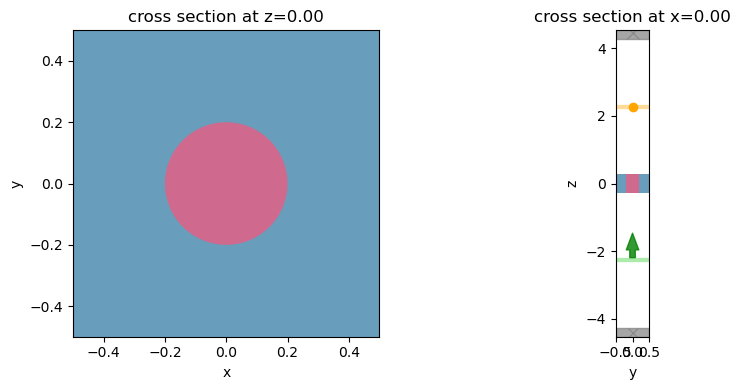

In [10]:
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
sim.plot(z=0., ax=ax[0]);
sim.plot(x=0, freq=freq0, ax=ax[1]);
plt.show()

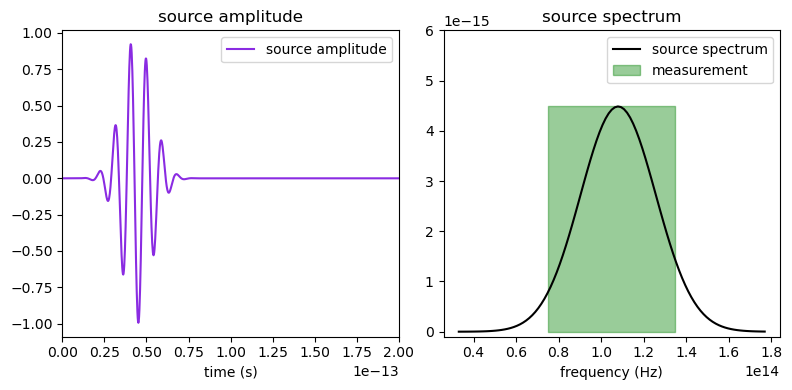

In [12]:
# Check probe and source
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
plot_time = 0.2e-12
ax1 = sim.sources[0].source_time.plot(times=np.linspace(0, plot_time, 1001), ax=ax1)
ax1.set_xlim(0, plot_time)
ax1.legend(('source amplitude',))
ax2 = sim.sources[0].source_time.plot_spectrum(times=np.linspace(0, sim.run_time, 10001), val = 'abs', ax=ax2)
fill_max = 45e-16
ymax = 60e-16
ax2.fill_between(freq_range, [-0e-16, -0e-16], [fill_max, fill_max], alpha=0.4, color='g')
ax2.legend(('source spectrum', 'measurement'))
ax2.set_ylim(-1e-16, ymax)
plt.show()

In [13]:
sim0 = sim.copy(update={'structures':[]})

In [14]:
sim_data0 = web.run(sim0, task_name='lecture03_PhC_normalization', path=f'data/data0_PhC_run{runtime}_PML{dPML}.hdf5')
sim_data = web.run(sim, task_name='lecture03_PhC_transmission', path=f'data/data_PhC_run{runtime}_PML{dPML}.hdf5')

[16:27:14] Created task 'lecture03_PhC_normalization' with task_id                                    ]8;id=978462;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=823097;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#189\189]8;;\
           'fdve-4a885d00-5da5-466b-9cbf-9b74a9b3cf8dv1'.                                                          

           View task using web UI at                                                                  ]8;id=223520;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=761236;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#191\191]8;;\
           ]8;id=592703;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4a885d00-5da5-466b-9cbf-9b74a9b3cf8dv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=982599;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4a885d00-5da5-466b-9cbf-9b74a9b3cf8dv1\taskId]8;;\]8;id=592703;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4a885d00-5da5-466b-9cbf-9b74a9b3cf8dv1\=]8;;\]8;id=430699;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4a885d00-5da5-466b-9cbf-9b74a9b3cf8dv1\fdve]8;;\]8;id=592703;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4a885d00-5da5-466b-9cbf-9b74a9b3cf8dv1\-4a885d00-5da5-466b-9cbf-9b74a9b3cf8]8;;\              
           ]8;id=592703;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4a885d00-5da5-466b-9cbf-9b74a9b3cf8dv1\dv1']8;;\.                                                                                                   

Output()

[16:27:17] status = queued                                                                            ]8;id=870438;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=137399;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#363\363]8;;\

Output()

[16:27:21] status = preprocess                                                                        ]8;id=301727;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=672450;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#357\357]8;;\

[16:27:26] Maximum FlexCredit cost: 0.044. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=709145;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=507190;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#343\343]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=833863;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=523962;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#379\379]8;;\

           running solver                                                                             ]8;id=904471;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=42720;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#389\389]8;;\

           To cancel the simulation, use 'web.delete(task_id)' or delete the task in the web UI.      ]8;id=354006;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=822732;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\
           Terminating the Python script will not stop the job running on the cloud.                               

Output()

[16:27:34] early shutoff detected, exiting.                                                           ]8;id=419990;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=174708;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#407\407]8;;\

[16:27:35] status = postprocess                                                                       ]8;id=972300;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=229788;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#424\424]8;;\

Output()

[16:27:39] status = success                                                                           ]8;id=327803;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=261720;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#431\431]8;;\

Output()

[16:27:42] loading SimulationData from data/data0_PhC_run100.0_PML1.0.hdf5                            ]8;id=438035;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=269056;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#609\609]8;;\

[16:27:42] Created task 'lecture03_PhC_transmission' with task_id                                     ]8;id=756473;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=700015;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#189\189]8;;\
           'fdve-a250b566-cff5-4654-aaa4-5a06e64adae9v1'.                                                          

           View task using web UI at                                                                  ]8;id=849433;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=167486;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#191\191]8;;\
           ]8;id=443597;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a250b566-cff5-4654-aaa4-5a06e64adae9v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=759694;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a250b566-cff5-4654-aaa4-5a06e64adae9v1\taskId]8;;\]8;id=443597;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a250b566-cff5-4654-aaa4-5a06e64adae9v1\=]8;;\]8;id=499067;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a250b566-cff5-4654-aaa4-5a06e64adae9v1\fdve]8;;\]8;id=443597;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a250b566-cff5-4654-aaa4-5a06e64adae9v1\-a250b566-cff5-4654-aaa4-5a06e64adae]8;;\              
           ]8;id=443597;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a250b566-cff5-4654-aaa4-5a06e64adae9v1\9v1']8;;\.                                                                                                   

Output()

[16:27:45] status = queued                                                                            ]8;id=795195;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=163257;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#363\363]8;;\

Output()

[16:27:49] status = preprocess                                                                        ]8;id=574994;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=987140;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#357\357]8;;\

[16:27:54] Maximum FlexCredit cost: 0.044. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=55668;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=919813;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#343\343]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=409939;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=244035;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#379\379]8;;\

           running solver                                                                             ]8;id=692154;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=914283;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#389\389]8;;\

           To cancel the simulation, use 'web.delete(task_id)' or delete the task in the web UI.      ]8;id=464531;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=18889;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\
           Terminating the Python script will not stop the job running on the cloud.                               

Output()

[16:28:31] early shutoff detected, exiting.                                                           ]8;id=360632;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=845550;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#407\407]8;;\

[16:28:32] status = postprocess                                                                       ]8;id=179637;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=371891;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#424\424]8;;\

Output()

Output()

[16:28:44] loading SimulationData from data/data_PhC_run100.0_PML1.0.hdf5                             ]8;id=535115;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=57008;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#609\609]8;;\

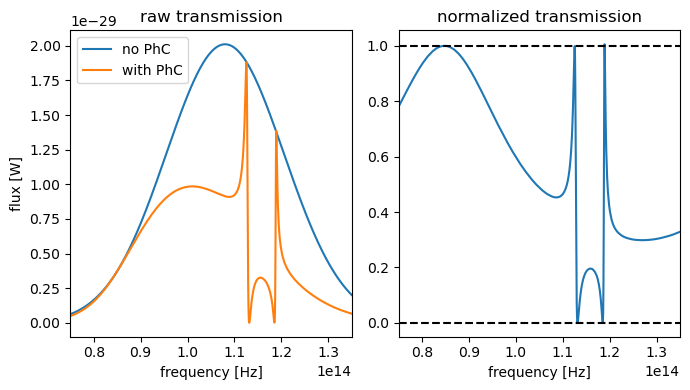

In [16]:
# Retrieve the power flux through the monitor plane.

transmission0 = sim_data0['flux'].flux
transmission = sim_data['flux'].flux
transmission_normalized = transmission / transmission0

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), tight_layout=True)
transmission0.plot(ax=ax1, label='no PhC')
transmission.plot(ax=ax1, label='with PhC')
ax1.set_xlim((freq_range[0],freq_range[1]))
transmission_normalized.plot(ax=ax2)
ax2.hlines(1.0,freq_range[0],freq_range[1],linestyles='dashed',color='black')
ax2.hlines(0.0,freq_range[0],freq_range[1],linestyles='dashed',color='black')
ax2.set_xlim((freq_range[0],freq_range[1]))
ax1.legend()
ax1.set_title('raw transmission')
ax2.set_title('normalized transmission')
plt.show()

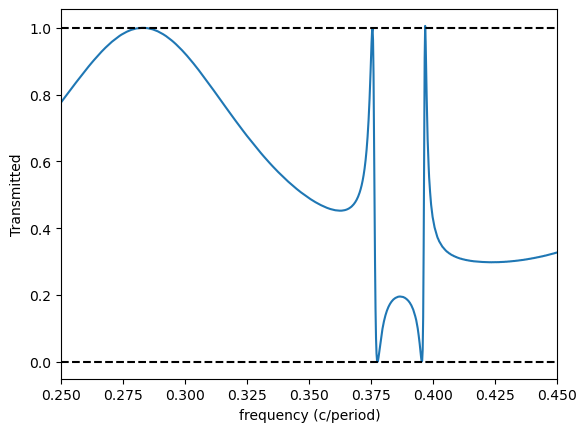

In [17]:
plt.figure()
plt.plot(monitor_freqs*period/td.C_0, transmission_normalized, label='normalized transmission')
plt.xlabel('frequency (c/period)')
plt.xlim([0.25, 0.45])
plt.hlines(1.0,0.25,0.45,linestyles='dashed',color='black')
plt.hlines(0.0,0.25,0.45,linestyles='dashed',color='black')
plt.ylabel('Transmitted')
plt.show()

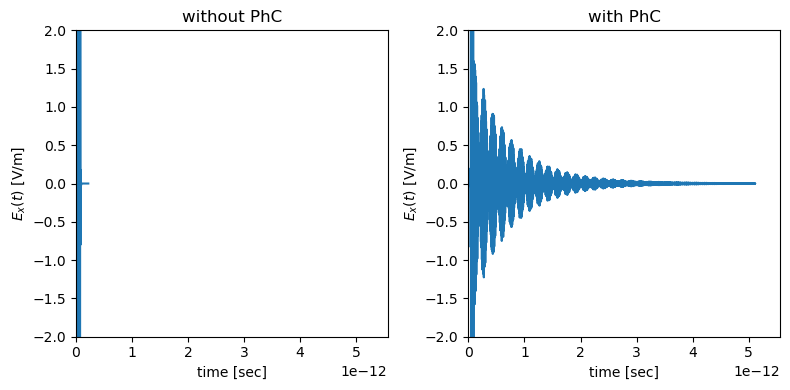

In [18]:
time_data = sim_data['time']
time_data0 = sim_data0['time']
fig, ax = plt.subplots(1,2,figsize=(8, 4), tight_layout=True)
ylim = 2
xlim = t_stop
# with PhC
Ex = time_data.Ex
Ex.plot(ax=ax[1])
ax[1].set_ylim([-ylim,ylim])
ax[1].set_xlim([0,xlim])
ax[1].set_ylabel('$E_x(t)$ [V/m]')
ax[1].set_title('with PhC')
# without PhC
Ex0 = time_data0.Ex
Ex0.plot(ax=ax[0])
ax[0].set_ylabel('$E_x(t)$ [V/m]')
ax[0].set_xlim([0,xlim])
ax[0].set_ylim([-ylim,ylim])
ax[0].set_title('without PhC')

plt.show()